# CellRank2 analysis of TE001

CellRank2 analysis of TE001 using CellRank2 VIPER-Based Kernel

### a) Import packages and data

Setup path to data-containing folder and savings and parameters

In [1]:
# a.1) setup path to data-containing folder and savings and parameters
h5ad_path = "/Users/AlexanderWang/Desktop/ics-rebuttal/TE001-h5ad/"
figures_dir = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/"
figures_dir_VIPERKernel = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/"
figures_dir_TE001 = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/TE001/"

n_macro_CytoTRACE = 8 # number of macrostates 

Import packages and set markers of interest

In [2]:
# a.2) packages
import sys
import cellrank as cr
from VIPERKernel import VIPERKernel
import scanpy as sc
import numpy as np
import pandas as pd
import os
from matplotlib import rc_context
import matplotlib.pyplot as plt
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

import warnings
warnings.simplefilter("ignore", category=UserWarning)

cytotrace_markers = ['Smarca5','Rbbp7','Tcerg1','Hnrnpd','Hmg20b','Nelfe','Ube2i','Etv5','Ubn1','Mbd3','Dek','Maz',
                     'Itgb3bp','Ilf2','Pa2g4'] # Id3','Hnf4g','Atoh1','Spdef','Neurod1' markers upregulated in cytotrace (Fig 1e) 

Load counts data and metadata for TE001. Setup UMAP coordinates for UMAP visualization

In [3]:
# a.3) load counts data (exported from Seurat@RNA assay)
counts_h5ad = h5ad_path + "TE001-subnetworks-one-signature-seurat-viper-analysis-with-metacell-data-with-paneth.h5ad"
adata = sc.read_h5ad(counts_h5ad) # load in object

# a.4) load metadata for TE001 
metadata_csv = h5ad_path + "TE001-metadata-umap-and-clusters-for-paper.csv"
metadata = pd.read_csv(metadata_csv)

In [4]:
# a.5) process metadata in adata
specified_columns = ["cell_id", "nCount_VIPER", "nFeature_VIPER", "mt_percent", "cytotrace_score.ges",
                     "seurat_clusters", "singleR_labels"]

adata.obs = adata.obs[specified_columns]
cells_to_analyze = metadata['cell_id'] # cells to analyze
adata = adata[adata.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata

adata.obs = pd.merge(adata.obs, metadata, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object

adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype('category') # VIPER clusters as categorical variable
adata.obs['seurat_clusters.ges'] = adata.obs['seurat_clusters.ges'].astype('category') # GES clusters as categorical variable

# a.6) set UMAP coordinates to those obtained at protein activty
umap_coordinates = np.array(adata.obs.loc[:, ['UMAP_1_scanpy','UMAP_2_scanpy']]) 
adata.obsm['X_umap'] = umap_coordinates

# a.7) Include metadata of terminal states for CellRank analysis
adata.obs['terminal_states'] = adata.obs['iter_cluster_id_with_paneth']
adata.obs['terminal_states'].iloc[adata.obs['terminal_states'].isin(["stem-1","stem-2"])] = np.nan

In [5]:
adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype('category') # VIPER clusters as categorical variable
adata.obs['seurat_clusters.ges'] = adata.obs['seurat_clusters.ges'].astype('category') # GES clusters as categorical variable

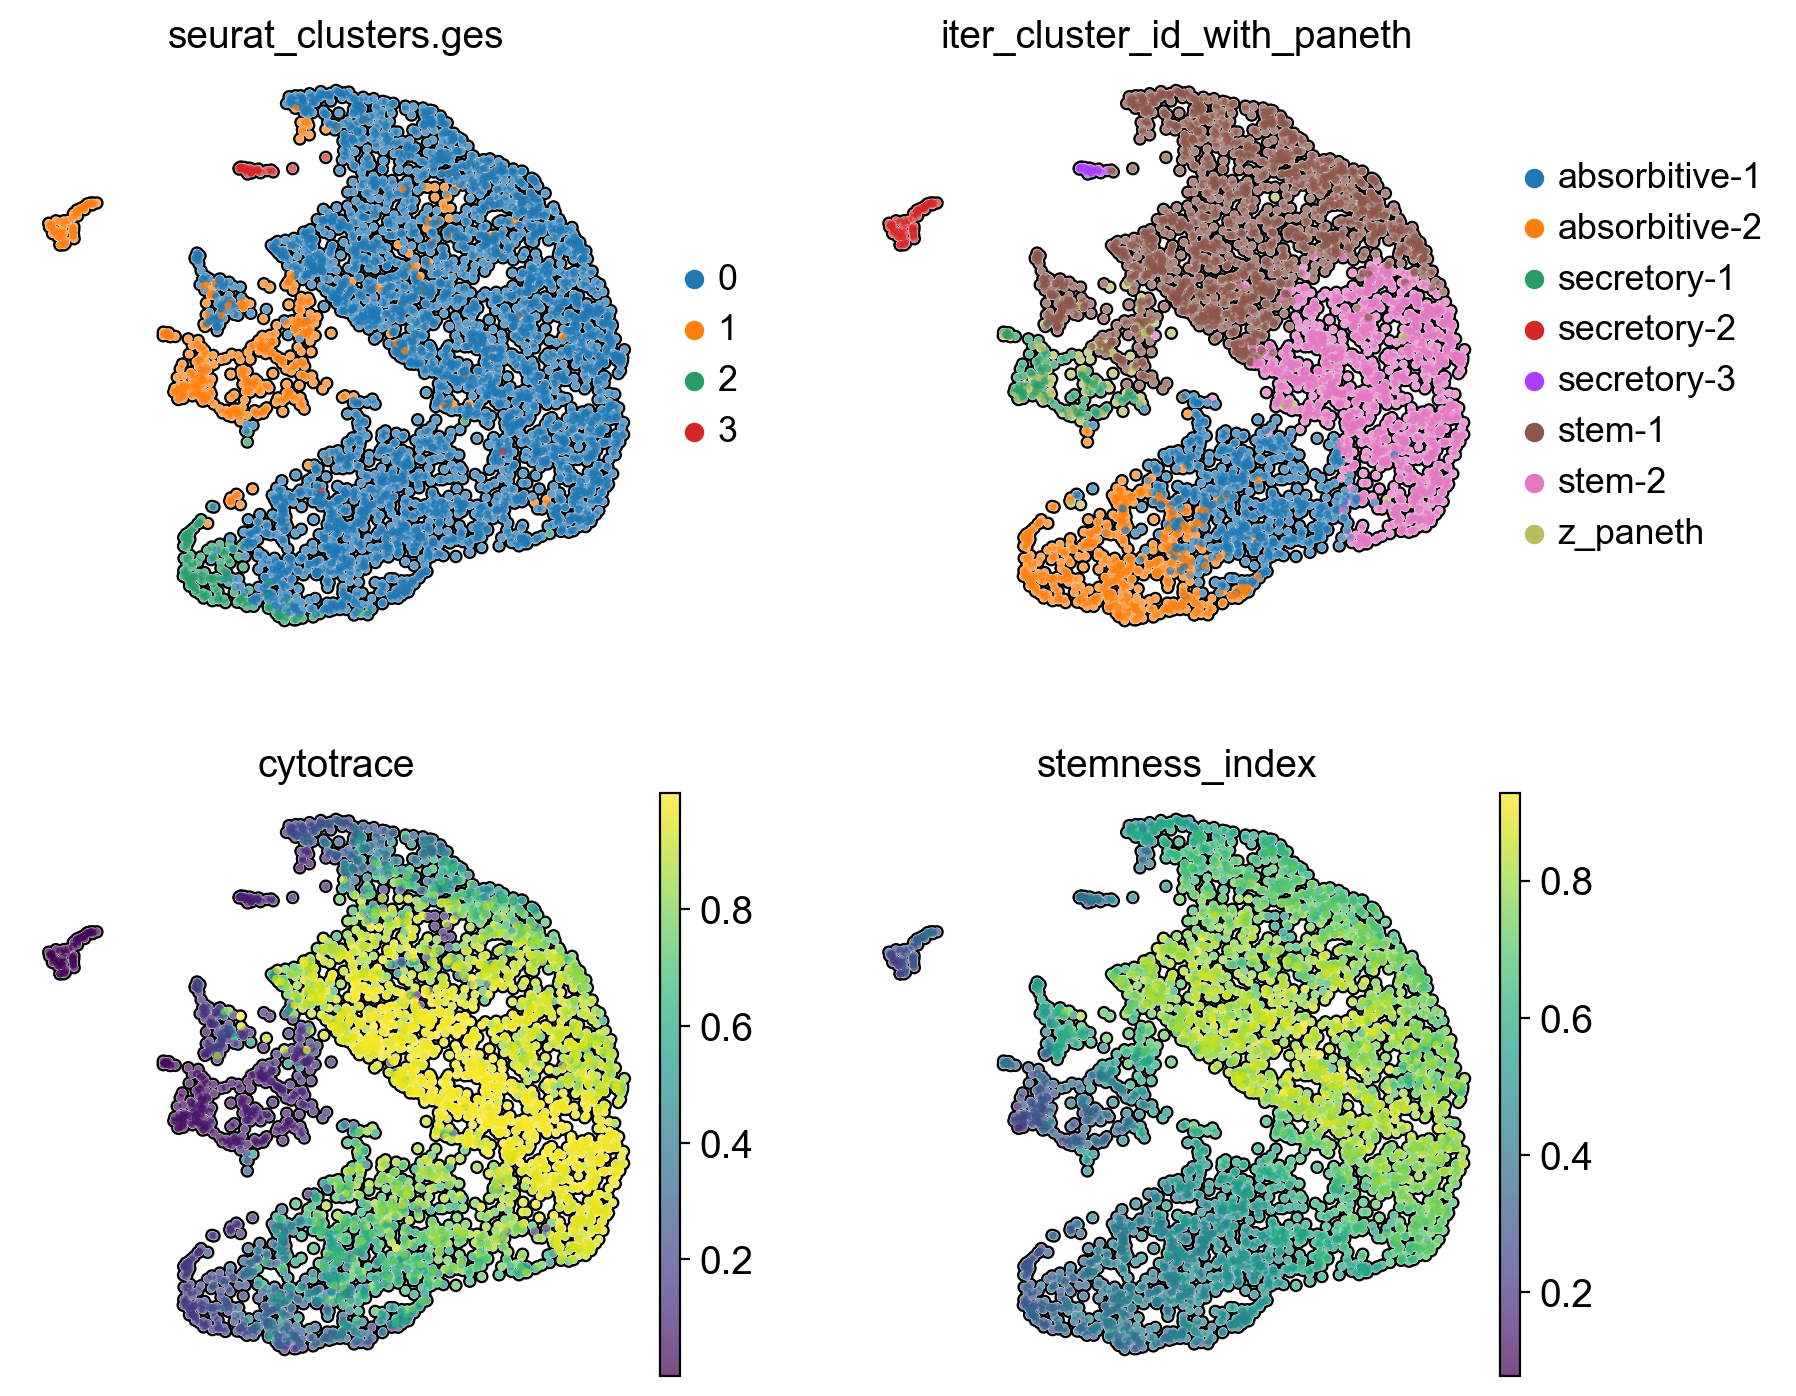

In [6]:
sc.pl.umap(adata, color=["seurat_clusters.ges","iter_cluster_id_with_paneth","cytotrace","stemness_index"], ncols=2, add_outline=True)

Preprocess data for CellRank2 analysis

In [7]:
### b) Preprocess the data 
print("Preprocessing counts matrix for CellRank 2 analysis")
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)

Preprocessing counts matrix for CellRank 2 analysis


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## CellRank2 analysis with CytoTRACE Kernel

Compute transition matrix using our VIPER-based kernel for CellRank2 analysis

In [8]:
##########################################################################################################
##########################################################################################################
### CellRank2 analysis with VIPER-based Kernel
##########################################################################################################
##########################################################################################################

### c) VIPER-based Kernel
# c.1) Setup kernel
print("Working with VIPER-based kernel")
vpk = VIPERKernel(adata)

Working with VIPER-based kernel


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3656/3656 [00:02<00:00, 1513.66it/s]


Compute VIPER-based transition matrix and use it to create a kernel

In [9]:
# c.2) Set up figure directories
if os.path.exists(figures_dir):
    print("'figures_dir' directory already exists")
else:
    os.mkdir(figures_dir)

if os.path.exists(figures_dir_VIPERKernel):
    print("'figures_dir_VIPERKernel' directory already exists")
else:
    os.mkdir(figures_dir_VIPERKernel)

if os.path.exists(figures_dir_TE001):
    print("'figures_dir_TE001' directory already exists")
else:
    os.mkdir(figures_dir_TE001)

'figures_dir' directory already exists
'figures_dir_VIPERKernel' directory already exists
'figures_dir_TE001' directory already exists


Simulate random walk on the Markov Chain implied by the transition matrix. Starting cells are selected at random. In the first figure, starting cells are selected randomly from all clusters. In figures 2 and 3 they are randomly sampled from the 'stem-1' and 'stem-2' clusters. 100 trajectories are simulated in each Random Walk. Black dots = cells of departure; yellow dots = cells of arrival.

Simulating `100` random walks of maximum length `914`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:03)
Plotting random walks
Simulating `100` random walks of maximum length `914`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:03)
Plotting random walks
Simulating `100` random walks of maximum length `914`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:03)
Plotting random walks


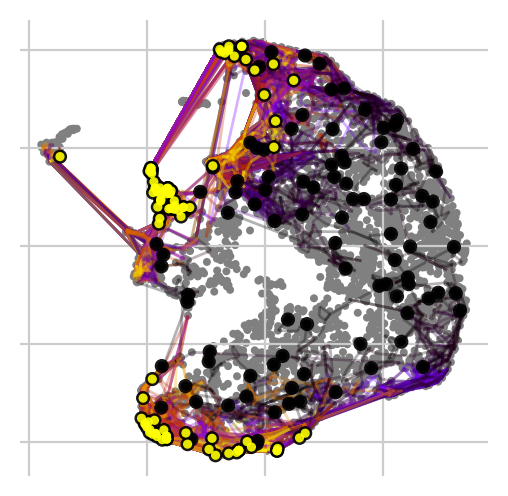

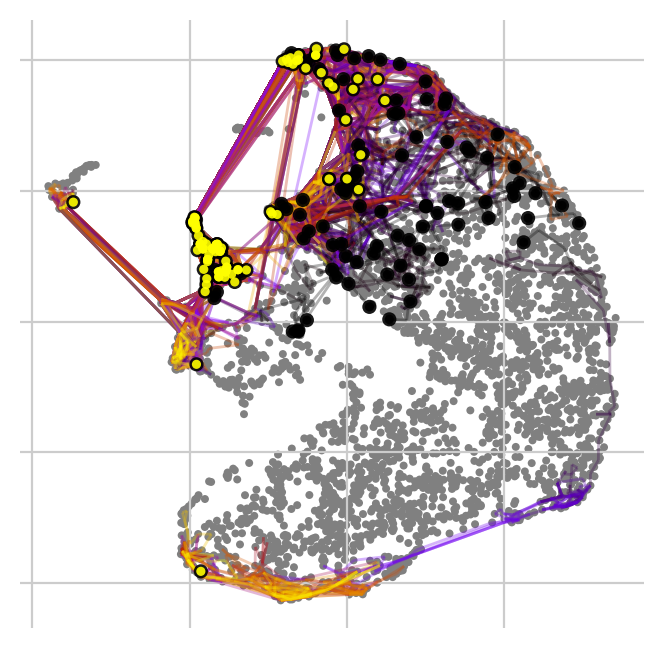

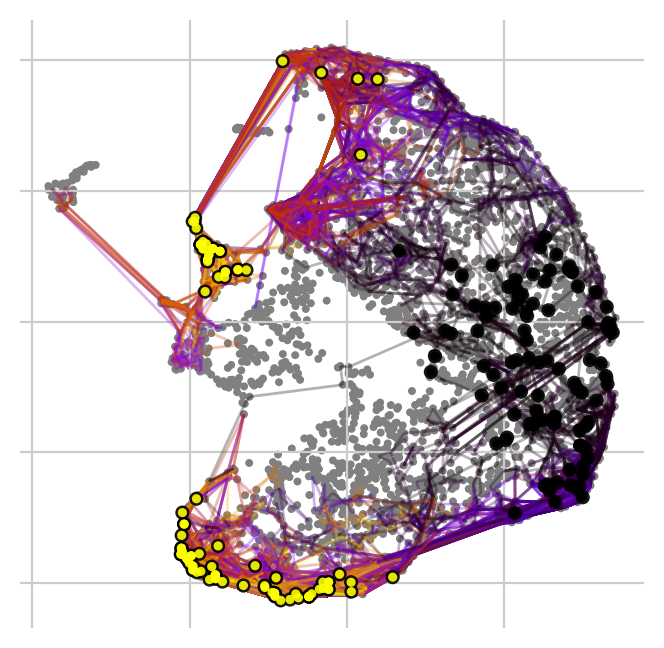

In [10]:
# c.3) Simulate a random walk on the Markov chain implied by the transition matrix 
vpk_rw_figure = figures_dir_TE001 + "VIPERKernel_random_walk.pdf"
vpk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs=None,
    legend_loc="right",
    dpi=100,
    save=vpk_rw_figure,
    figsize=(3,3)
)

# c.4) Simulate a random walk on the Markov chain implied by the transition matrix 
# sampling cells randomly among all clusters
vpk_rw_figure = figures_dir_TE001 + "VIPERKernel_random_walk_stem-1.pdf"
vpk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={'iter_cluster_id_with_paneth':'stem-1'},
    legend_loc="right",
    dpi=100,
    save=vpk_rw_figure
)

# c.5) visualize the transition matrix
# sampling cells randomly from stem-1 population
vpk_rw_figure = figures_dir_TE001 + "VIPERKernel_random_walk_stem-2.pdf"
vpk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={'iter_cluster_id_with_paneth': "stem-2"},
    legend_loc="right",
    dpi=100,
    save=vpk_rw_figure
)


Visualize the projected Transition Probability matrix on the UMAP, with clusters colored at gene expression (panel 1) and protein activity (panel 2). Also, show what we consider as the most differentiated states in the dataset (panel 3).

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:00)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/TE001/VIPERKernel_differentiation_ges_clusters.svg


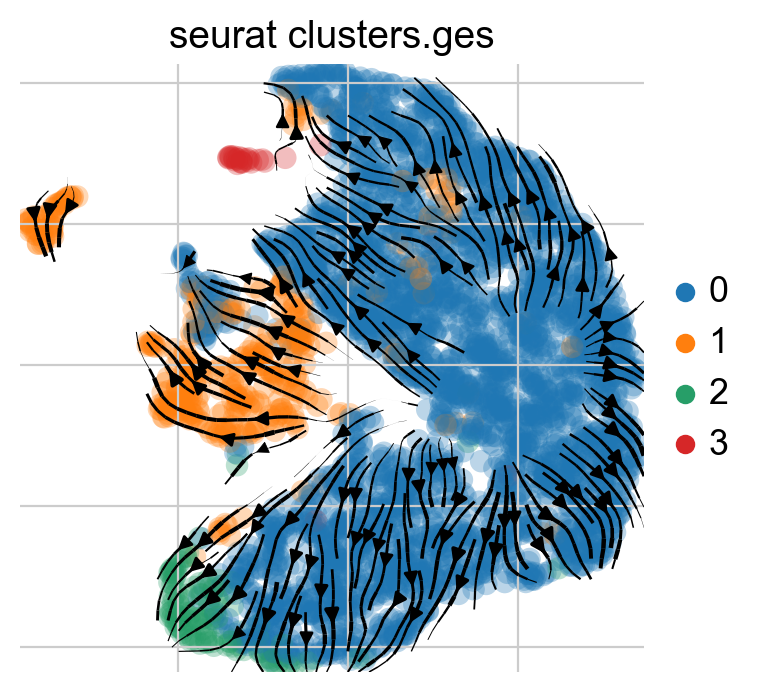

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/TE001/VIPERKernel_differentiation_pa_clusters.svg


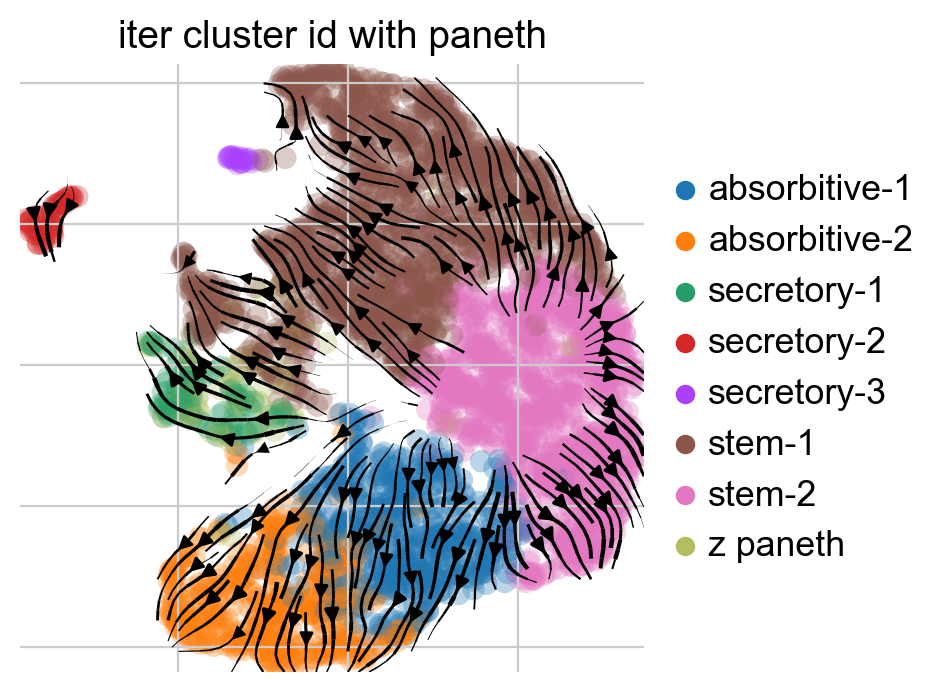

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/TE001/VIPERKernel_differentiation_cytotrace.svg


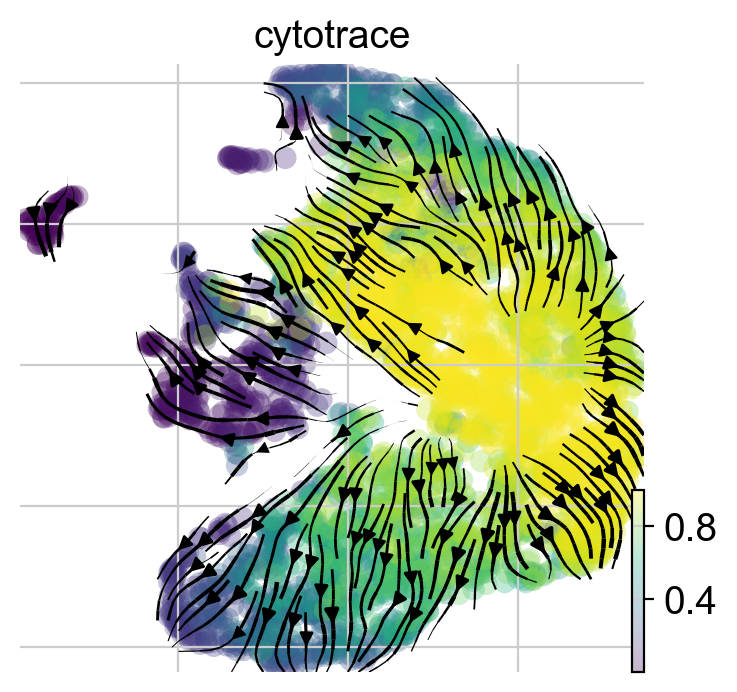

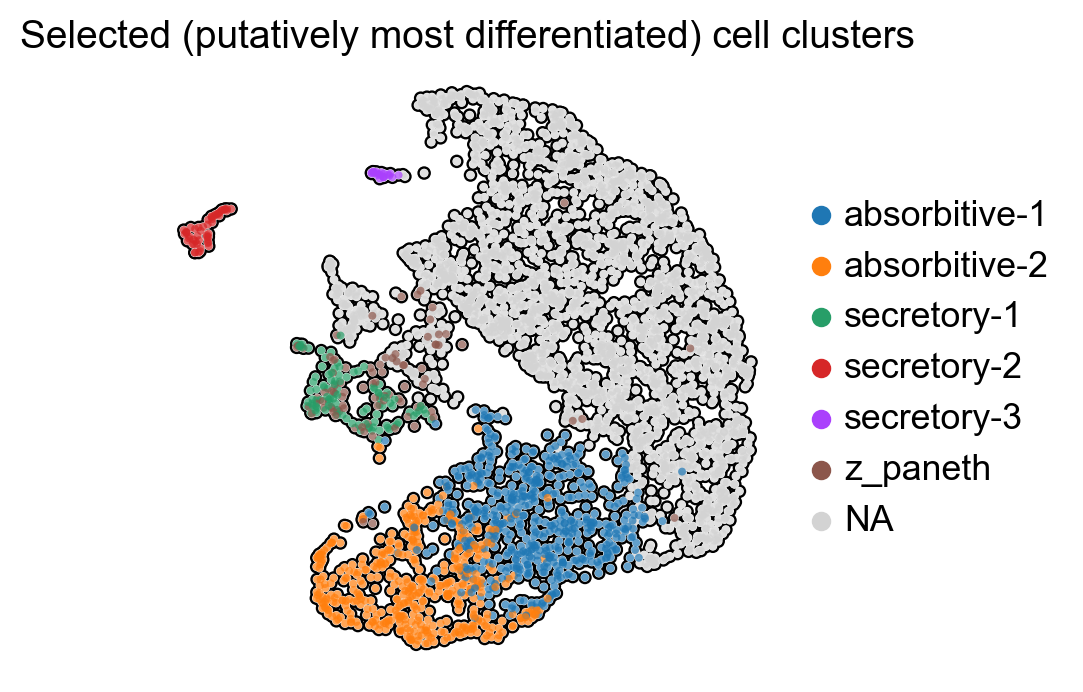

In [11]:
vpk.adata.obs['seurat_clusters'] = vpk.adata.obs['seurat_clusters'].astype('category') # clusters as categorical variable
vpk.adata.obs['seurat_clusters.ges'] = vpk.adata.obs['seurat_clusters.ges'].astype('category') # clusters as categorical variable
# c.6) visualize the transition matrix
differentiation_figure = figures_dir_TE001 + "VIPERKernel_differentiation_ges_clusters.svg"
vpk.plot_projection(basis="umap",
                    color="seurat_clusters.ges", 
                    legend_loc="right", save=differentiation_figure, show=True)


differentiation_figure = figures_dir_TE001 + "VIPERKernel_differentiation_pa_clusters.svg"
vpk.plot_projection(basis="umap",
                    color = "iter_cluster_id_with_paneth", 
                    legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE001 + "VIPERKernel_differentiation_cytotrace.svg"
vpk.plot_projection(basis="umap",
                    color="cytotrace", 
                    legend_loc="right", save=differentiation_figure, show=True)

# c.7) Check terminal states from annotations
annotated_terminal_states_figure = figures_dir_TE001 + "annotated_terminal_states.pdf"
sc.pl.embedding(adata, basis="umap", color="terminal_states", add_outline=True, title="Selected (putatively most differentiated) cell clusters") 
#####################

CellRank 2 (advanced) estimator-baed analysis of the Transition Matrix and calculation of the terminal states. Show the real value of the eigenvalues from Schur's decomposition (Figure 1), cell-type distrbution of the terminal states (Figure 2) and visualization of the coarse-grain transition matrix (Figure 3). To change the number of selected macrostate, change n_macro_CytoTRACE in the first cell of this notebook.

In [12]:
?g_vpk.compute_macrostates

Object `g_vpk.compute_macrostates` not found.


Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[12, 27, 33, 66, 74, 76, 78, 86, 89, 91, 94, 96, 98]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:19:47)
Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:08)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/TE001/GPCCA_macrostates.pdf
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/TE001/GPCCA_terminal_states.pdf


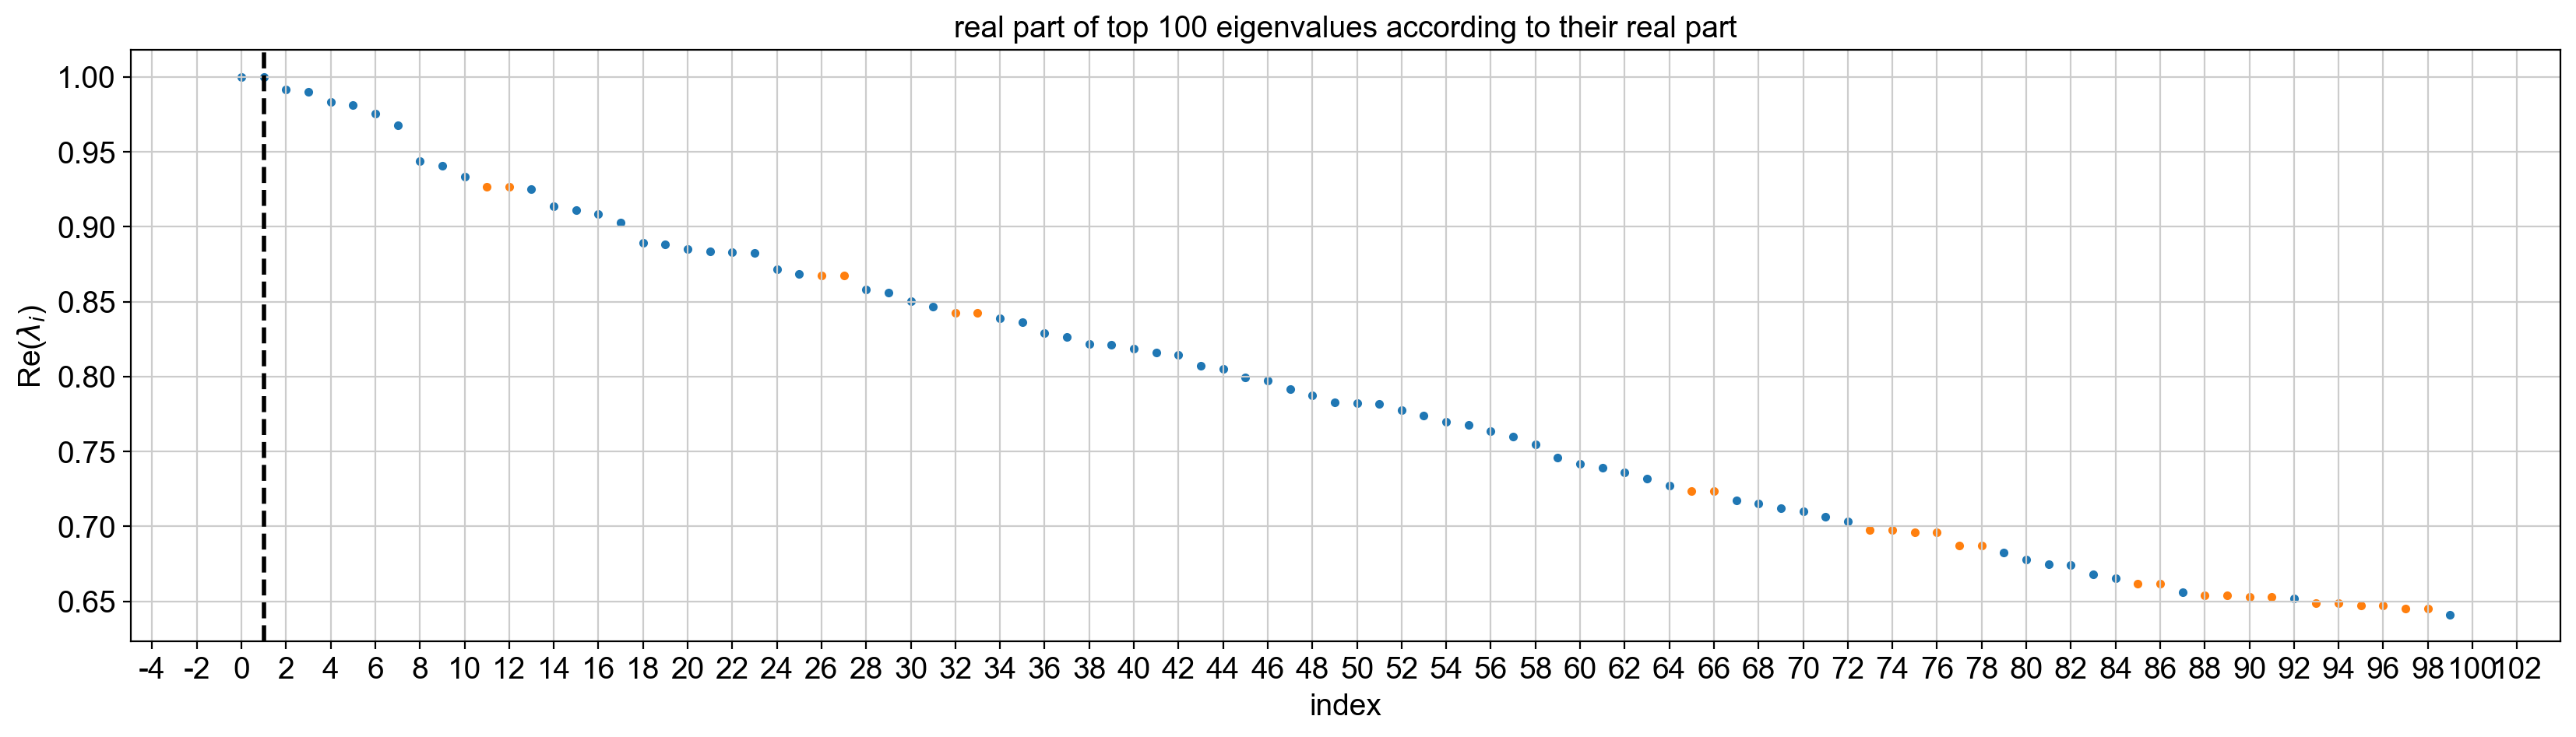

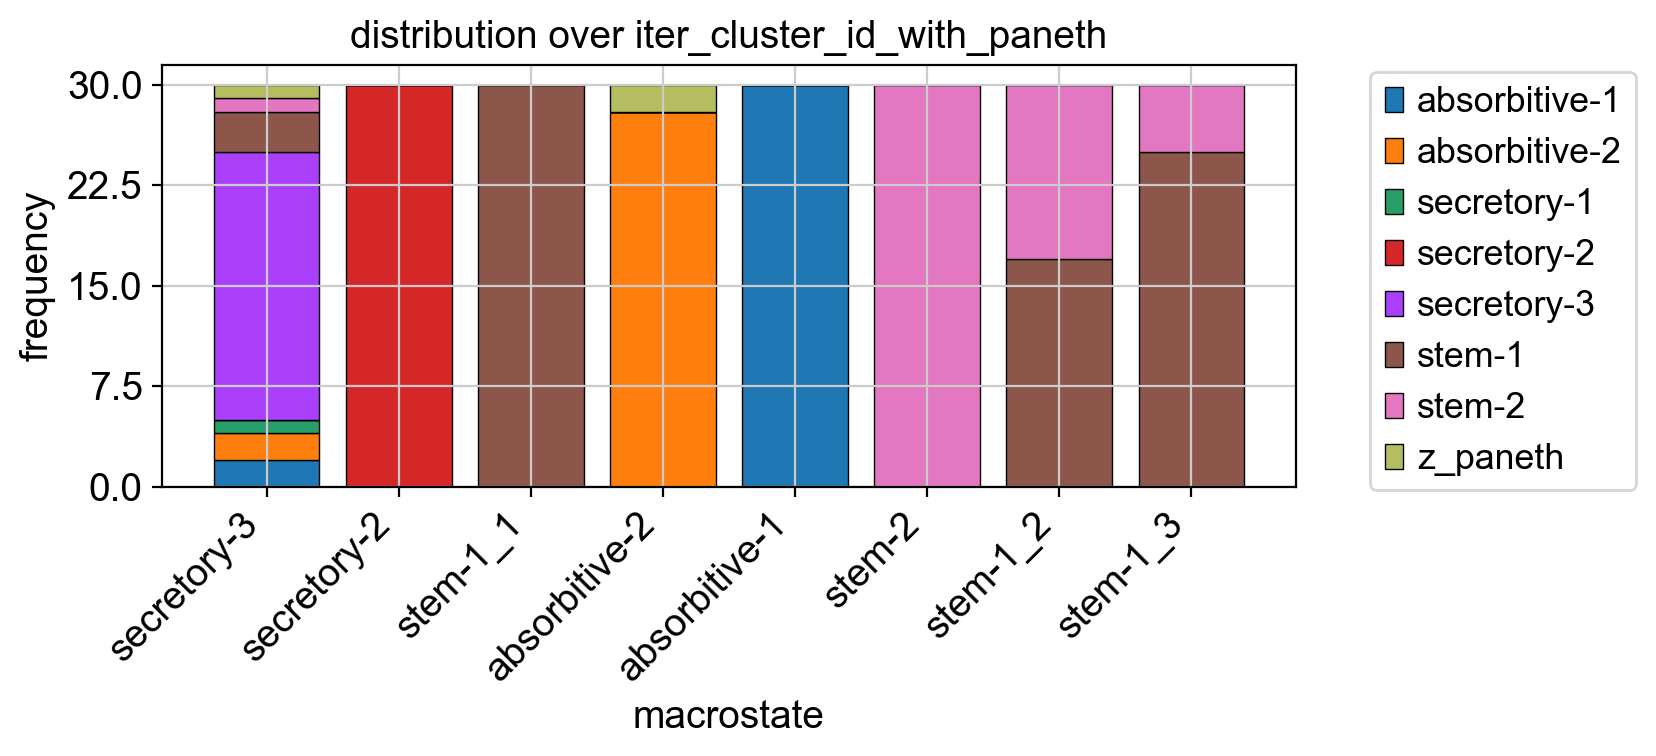

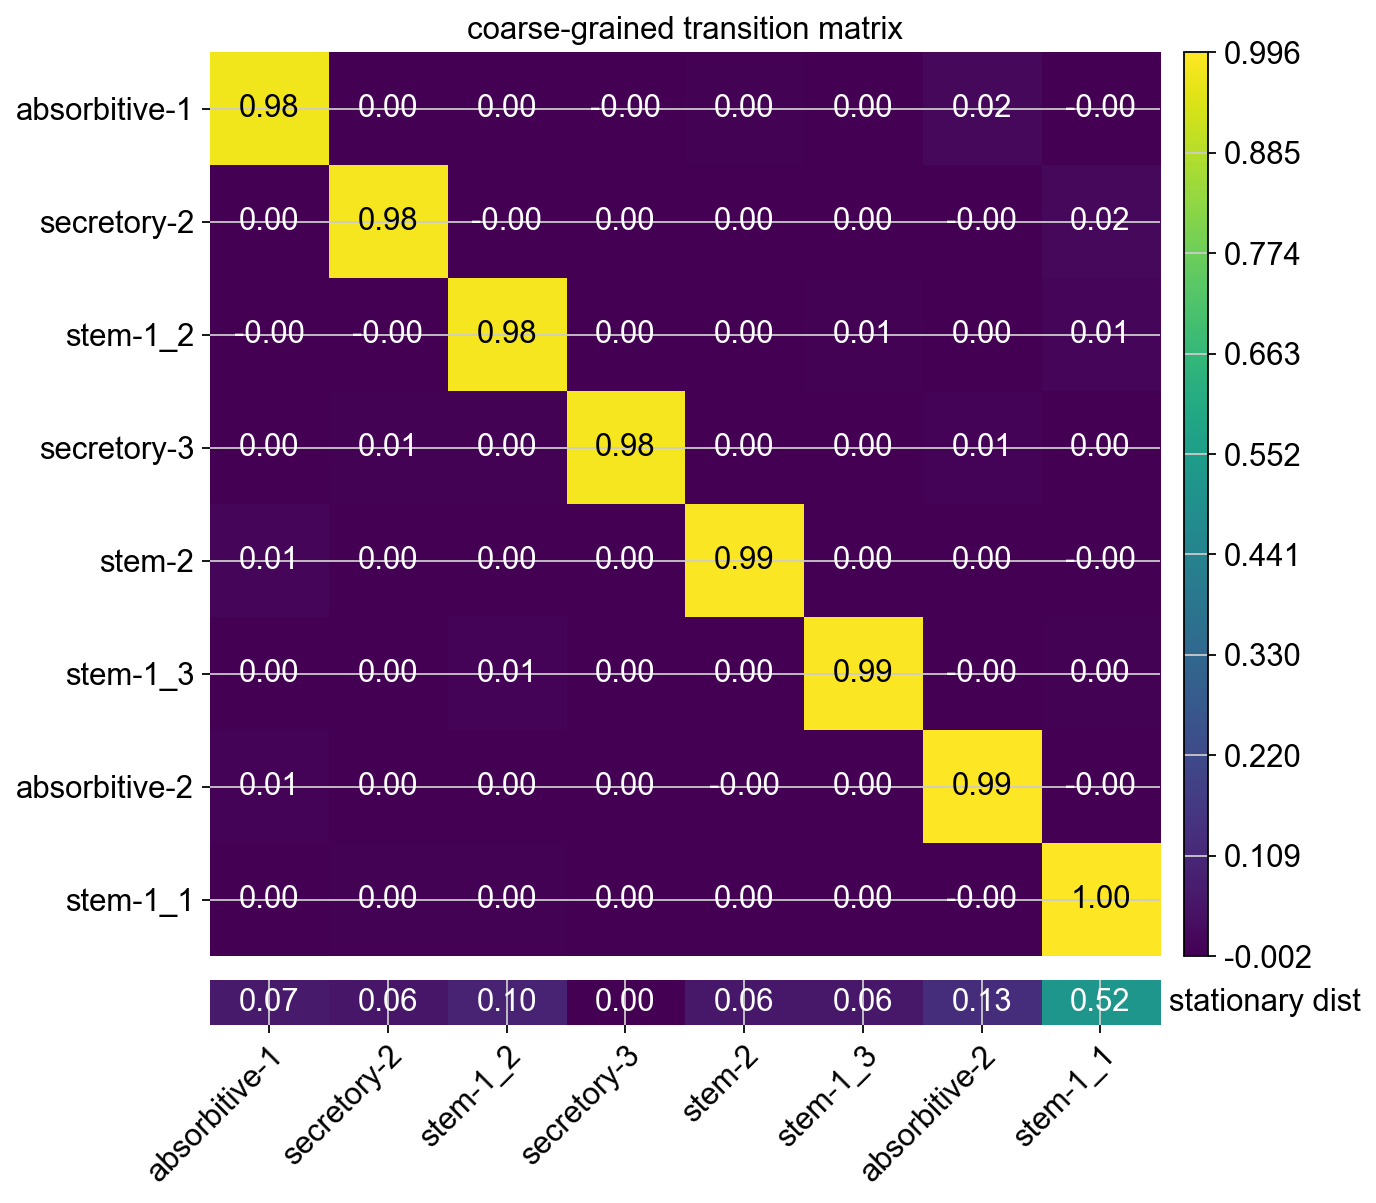

In [13]:
### d) Advanced estimator-based analysis of the CytoTRACE kernel with estimators 
from cellrank.estimators import GPCCA
from cellrank.estimators import CFLARE

# d.1) compute estimator
g_vpk = cr.estimators.GPCCA(vpk)
g_vpk.compute_schur(n_components=100) # compute Schur decomposition
eig_figure = figures_dir_TE001 + "GPCCA_eig.pdf"
g_vpk.plot_spectrum(real_only=True, n=None, show_all_xticks=False, save=eig_figure, figsize=(20,5))

g_vpk.compute_macrostates(n_states=n_macro_CytoTRACE, cluster_key="iter_cluster_id_with_paneth")
macrostates_figure = figures_dir_TE001 + "GPCCA_macrostates.pdf"
g_vpk.plot_macrostates(which="all", legend_loc="right", s=100, save=macrostates_figure, show=False)

macrostates_figure_composition = figures_dir_TE001 + "GPCCA_macrostates_composition.pdf"
g_vpk.plot_macrostate_composition(key="iter_cluster_id_with_paneth", figsize=(8.5,4), show=False, save=macrostates_figure_composition) # composition of each macrostate

coarse_T_figure = figures_dir_TE001 + "GPCCA_coarse_T.pdf"
g_vpk.plot_coarse_T(annotate=True, save=coarse_T_figure) # plot transition matrix

# d.2) compute terminal states
g_vpk.predict_terminal_states()
terminal_states_figure = figures_dir_TE001 + "GPCCA_terminal_states.pdf"
g_vpk.plot_macrostates(which="terminal", legend_loc="right", s=100, save=terminal_states_figure, show=False)

# d.3) predict initial states
#g_vpk.predict_initial_states(allow_overlap=True)
#g_vpk.plot_macrostates(which="initial", s=100)


Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


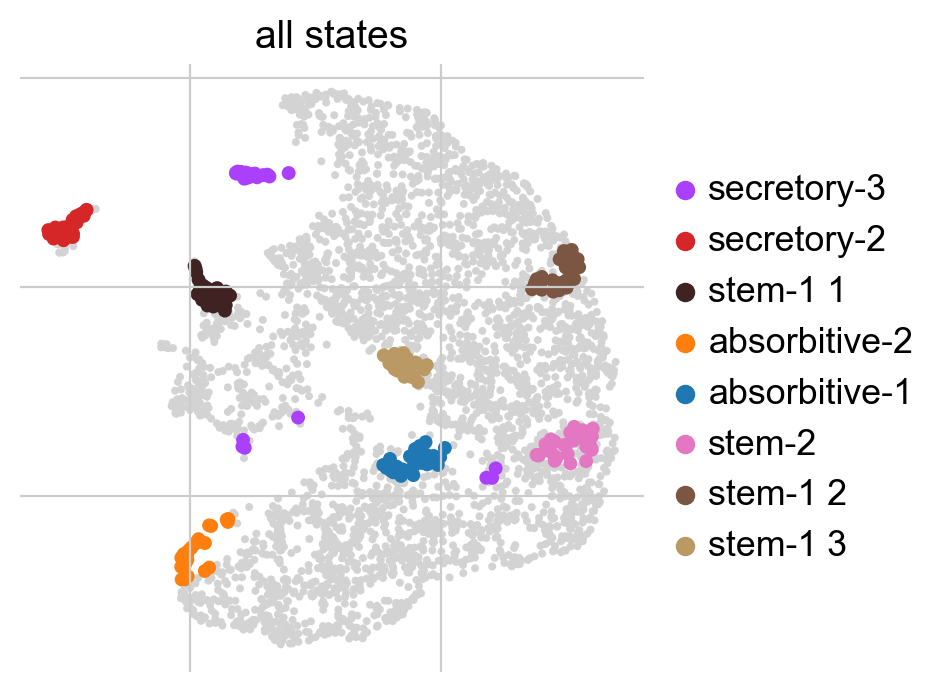

In [17]:
g_vpk.compute_macrostates(n_states=n_macro_CytoTRACE,
                          cluster_key="iter_cluster_id_with_paneth")
# macrostates_figure = figures_dir_TE001 + "GPCCA_macrostates.pdf"
g_vpk.plot_macrostates(which="all", legend_loc="right", s=100, show=True)

Compute a score based on the expression of the `cytotrace_markers` defined in the second cell of this notebook.

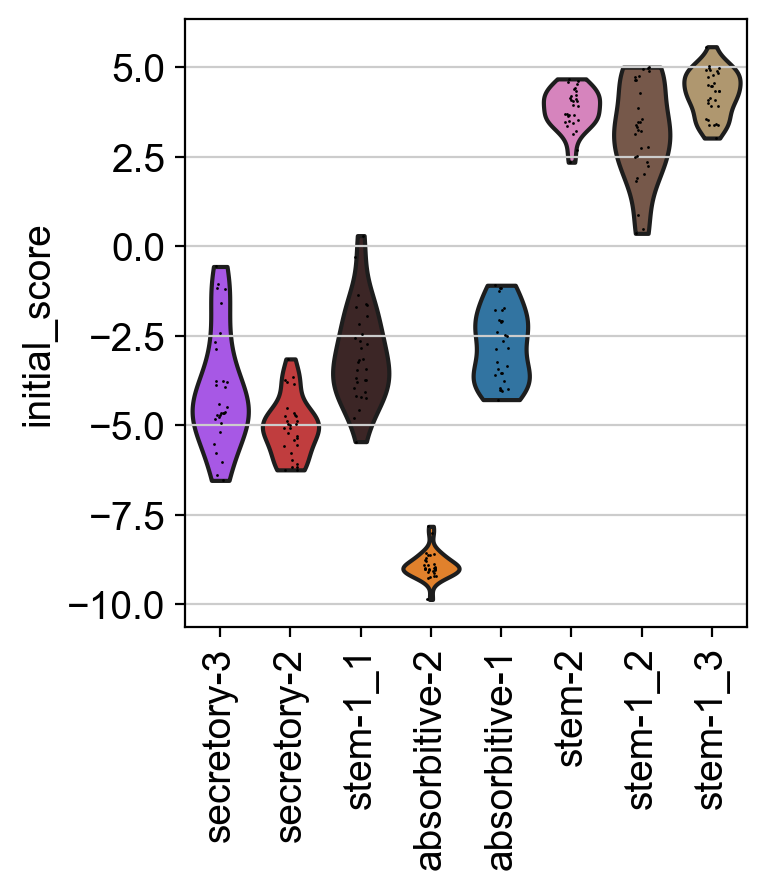

In [18]:
# d.4) verify the initial score by aggregating across cytotrace markers

sc.tl.score_genes(
    adata, gene_list=cytotrace_markers, score_name="initial_score", use_raw=False
) # compute a score in scanpy by aggregating across a few cytotrace markers
# collect macrostates to AnnData
adata.obs["macrostates"] = g_vpk.macrostates 
adata.uns["macrostates_colors"] = g_vpk.macrostates_memberships.colors
# visualize macrostates via initial_scores
sc.pl.violin(adata, keys="initial_score", groupby="macrostates", rotation=90)


Collect the inferred terminal states in a list for ease of manipulation.

In [23]:
inferred_terminal_states = g_vpk.terminal_states.unique().dropna().to_list()

Estimate Fate probabilities towards the identified terminal states

Computing fate probabilities


  0%|          | 0/8 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/TE001/Fate_probability.pdf


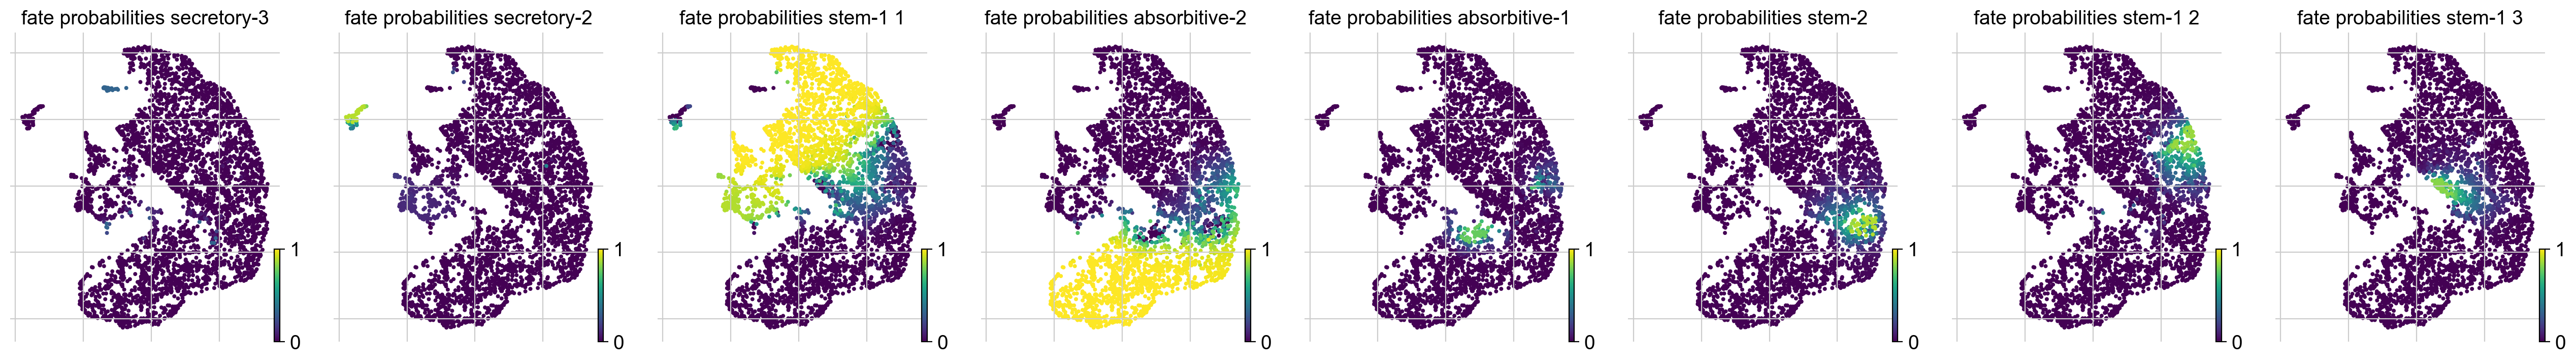

In [25]:
#########################################################
# f) Estimating Fate Probabilities 

# f.1) compute fate probabilities towards identified terminal states
g_vpk.compute_fate_probabilities()

# f.2) visualize fate probabilities on UMAP
fate_probability_figure = figures_dir_TE001 + "Fate_probability.pdf"
g_vpk.plot_fate_probabilities(same_plot=False, vmax=1,show=True, save=fate_probability_figure)

# # f.3) visualize fate probabilities on a circular projection
# fate_circular_figure = figures_dir_TE001 + "Fate_circular.pdf"
# cr.pl.circular_projection(adata, keys="iter_cluster_id_with_paneth", legend_loc="right", save=fate_circular_figure)

# # fate_circular_figure = figures_dir_TE001 + "Fate_circular_genes.pdf"
# # cr.pl.circular_projection(adata, keys=["log(Lgr4)", "log(Lgr5)", "log(Atad2)", "log(Mki67)"], cmap = "Oranges", ncols=2, legend_loc="right", save=fate_circular_figure)

# # f.4) aggregate fate probabilities and visualize how they are committed towards selected cell types   
# progenitor_states = ["stem-1", "stem-2"] # select stem-1 and stem-2 as the progenitor states to aggregate their probabilities
# fate_committed_vln_figure = figures_dir_TE001 + "Fate_committed_vln.pdf"
# cr.pl.aggregate_fate_probabilities(
#     adata,
#     mode="violin",
#     lineages=inferred_terminal_states,
#     cluster_key="iter_cluster_id_with_paneth",
#     clusters=progenitor_states,
#     save=fate_committed_vln_figure
# )